In [3]:
from power_spectra import * #look into this file. You need camb or class to get power spectra (there are wrapper functions for both). 
                            #The file imports both class and camb. Comment out relevant lines (at the top) if you don't have one of them.
from scipy.special import jn, jn_zeros
from scipy.interpolate import interp1d
from hankel_transform import *
from astropy.cosmology import Planck13 #use Planck15 if you can
import astropy.units as u
rc('text', usetex=False)
import scipy
from scipy.interpolate import interp1d

In [4]:
cosmo=Planck13.clone()#we want h=1 for some comparisons
cosmo_h=Planck13.clone(H0=100)#we want h=1 for some comparisons

In [5]:
#set parameters for power spectra computations.
#play around with kmax,kmin to find optimal values for your case (based on rmin,rmax). 
#Remember very high kmax or very low kmin will require finer grid, slowing down the initial setup of the hankel transform. 
#Subsequent calculations of correlation functions are fast, so speed should not be major issue when running fits.
#need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.
kmax=30
kmin=.8e-3
k_smooth=1
nk=5000
rmin=1
rmax=100
non_linear=1

r_bins=np.logspace(-1,np.log10(100),21) #np.logspace(0,2,11)

In [6]:
cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':non_linear,'kmax':kmax,'kmin':kmin,'nk':nk}

In [7]:
PS=Power_Spectra(cosmo_params=cosmo_fid,pk_params=pk_params)

In [8]:
sc1=PS.sigma_crit(zl=np.atleast_1d(0.27),zs=np.atleast_1d(0.45),cosmo_h=cosmo_h)
Oms=np.linspace(cosmo.Om0*.7,cosmo.Om0*1.3,11)
scs=np.zeros_like(Oms)
i=0
for om in Oms:
    cosmo_i=cosmo_h.clone(Om0=om)
    scs[i]=PS.sigma_crit(zl=np.atleast_1d(0.27),zs=np.atleast_1d(0.45),cosmo_h=cosmo_i).value[0,0]
    i+=1

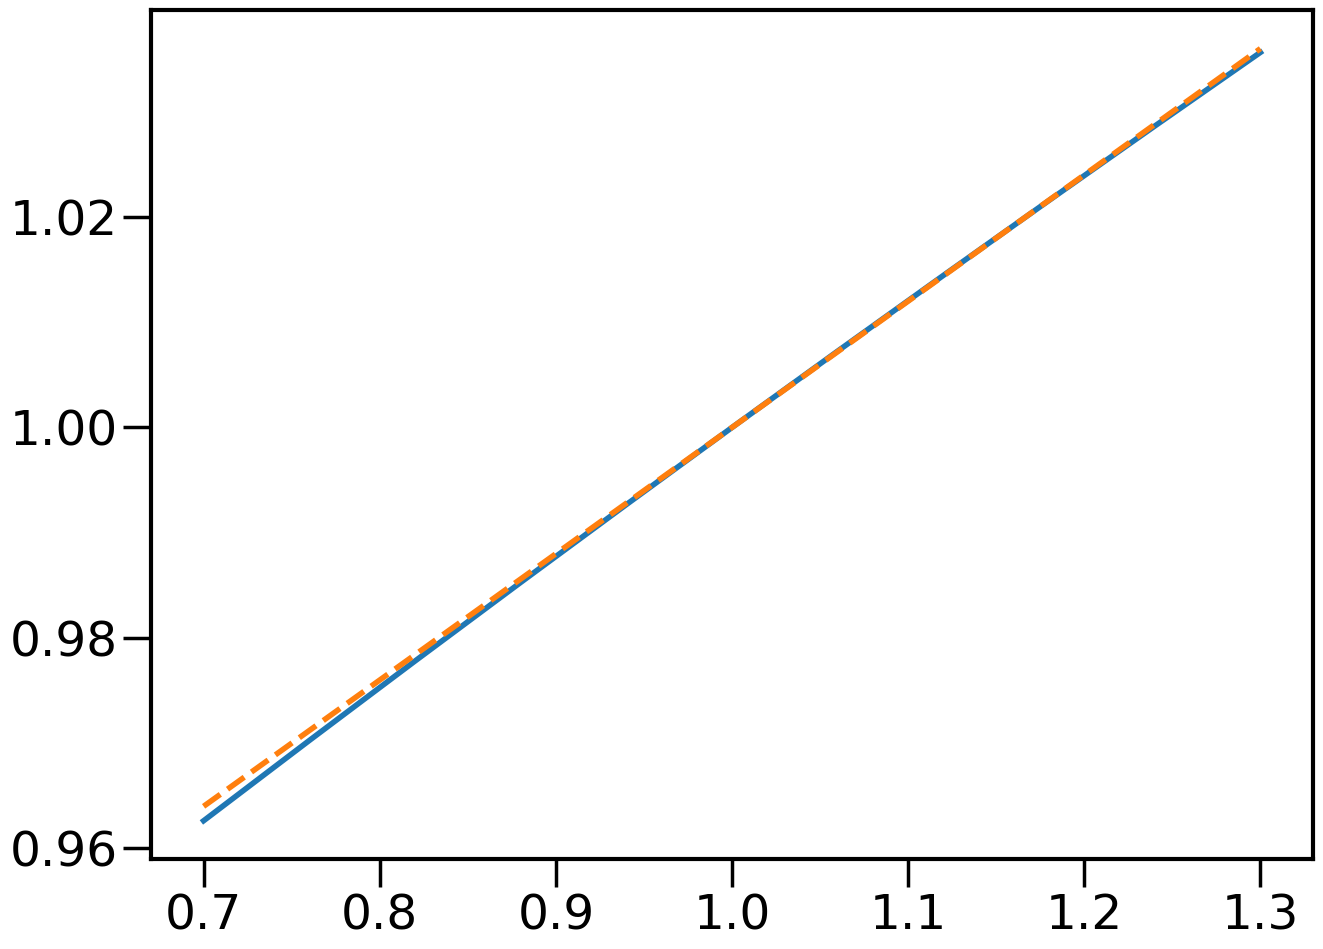

In [9]:
plot(Oms/Oms[5],scs/scs[5])
plot(Oms/Oms[5],(Oms/Oms[5])*.12+.88,'--')
# loglog()

In [10]:
z_min=0.16
z_max=0.36
z_mean=0.27

In [11]:
# pk,kh =PS.class_pk(z=[z_mean])
pk,kh =PS.camb_pk(z=[z_mean])

In [12]:
#Setting up the Hankel Transform
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0,2,4],n_zeros=28000,kmin=kmin)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
nr: 948
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 29000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 30000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 31000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 32000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 33000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 34000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 35000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 36000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 37000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 38000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 39000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 40000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 4100

In [13]:
pk_taper=HT.taper(k=kh,pk=pk[0],large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
                     low_k_upper=kmin*2)
#tapering helps to reduce ringing in the final correlation functions

In [14]:
from scipy.integrate import quad as scipy_int1d

In [15]:
cosmo.H(z=[0]).value

array([67.77])

In [16]:
def DZ_int(z=[0],cosmo=None,rtol=1.e-4,tol=1.e-5): #linear growth factor.. full integral.. eq 63 in Lahav and suto
        Ez_func=cosmo.efunc
        def intf(z):
            return (1.+z)/(cosmo.H(z=z).value**3)
        dz=np.zeros_like(z,dtype='float32')
        inf=np.inf
        j=0
        for i in z:
            dz[j]+=cosmo.H(i).value*scipy_int1d(intf,i,inf,epsrel=rtol,epsabs=tol)[0]
            j=j+1
        dz=dz*2.5*cosmo.Om0*cosmo.H0**2
        return dz/dz[0] #check for normalization

In [72]:
b_g=1.8
A_I=4.5
C1_rhoC=0.0134
Om=cosmo.Om0
Dz=DZ_int(z=np.append([0],z_mean),cosmo=cosmo)# Dz is normalized to 1 at lowest z. 
                                    #Hence appending 0 in front to get Dz normalized to 1 at z=0
Dz=Dz[1]/Dz[0]

#prefactors in front of wmm or wm+.
#if doing fits, set b_g and AI to be 1 here and then in the fitting function 
# you can simply multiply the correlation function with the correct values.
wgg_f=b_g**2
wgp_f=b_g*A_I*C1_rhoC*Om/Dz
wpp_f=(A_I*C1_rhoC*Om/Dz)**2

In [73]:
r_gg,wgg=HT.projected_correlation(k_pk=kh,pk=pk[0]*wgg_f,j_nu=0)
%time r_gg,wgg_taper=HT.projected_correlation(k_pk=kh,pk=pk_taper*wgg_f,j_nu=0)

r_gp,wgp=HT.projected_correlation(k_pk=kh,pk=pk[0]*wgp_f,j_nu=2)

r_pp,wpp4=HT.projected_correlation(k_pk=kh,pk=pk[0]*wpp_f,j_nu=4)
r_pp0,wpp0=HT.projected_correlation(k_pk=kh,pk=pk[0]*wpp_f,j_nu=0)

wpp0_intp=interp1d(r_pp0,wpp0,bounds_error=False,fill_value=np.nan)
wpp=wpp4+wpp0_intp(r_pp)

CPU times: user 107 ms, sys: 23.7 ms, total: 131 ms
Wall time: 8.11 ms


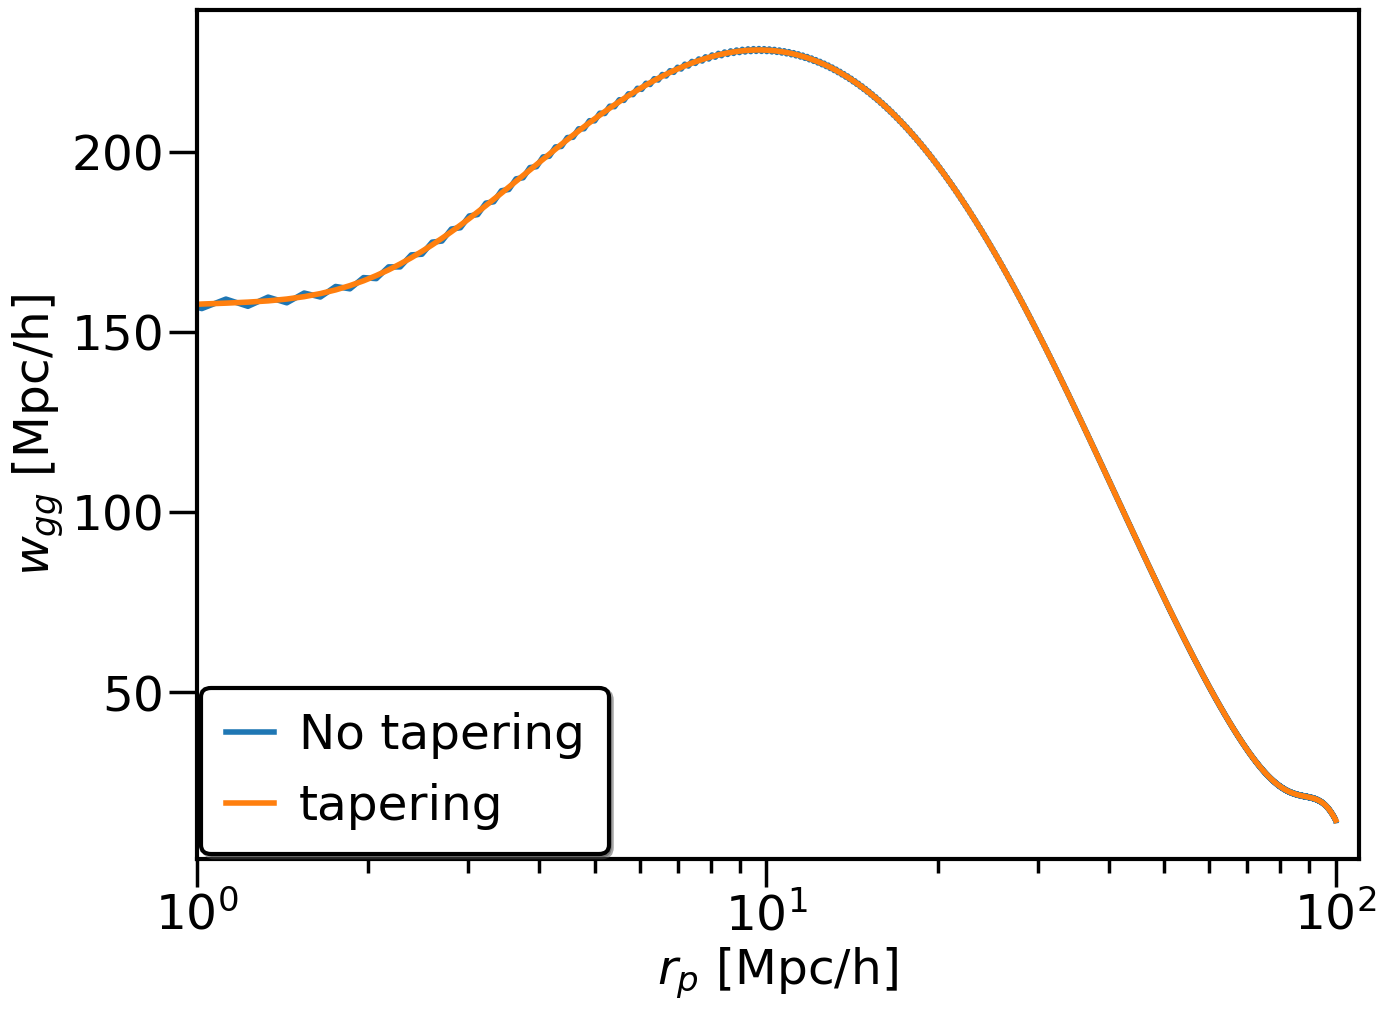

In [74]:
plot(r_gg,r_gg*wgg,label='No tapering')
plot(r_gg,r_gg*wgg_taper,label='tapering')
#plot(wgg_test['rp'],wgg_test['rp']*wgg_test['wgg']*wgg_test_fact)
xscale('log')
#yscale('log')
#ylim(1.e-2,1.e3)
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{gg}$ [Mpc/h]')

legend()

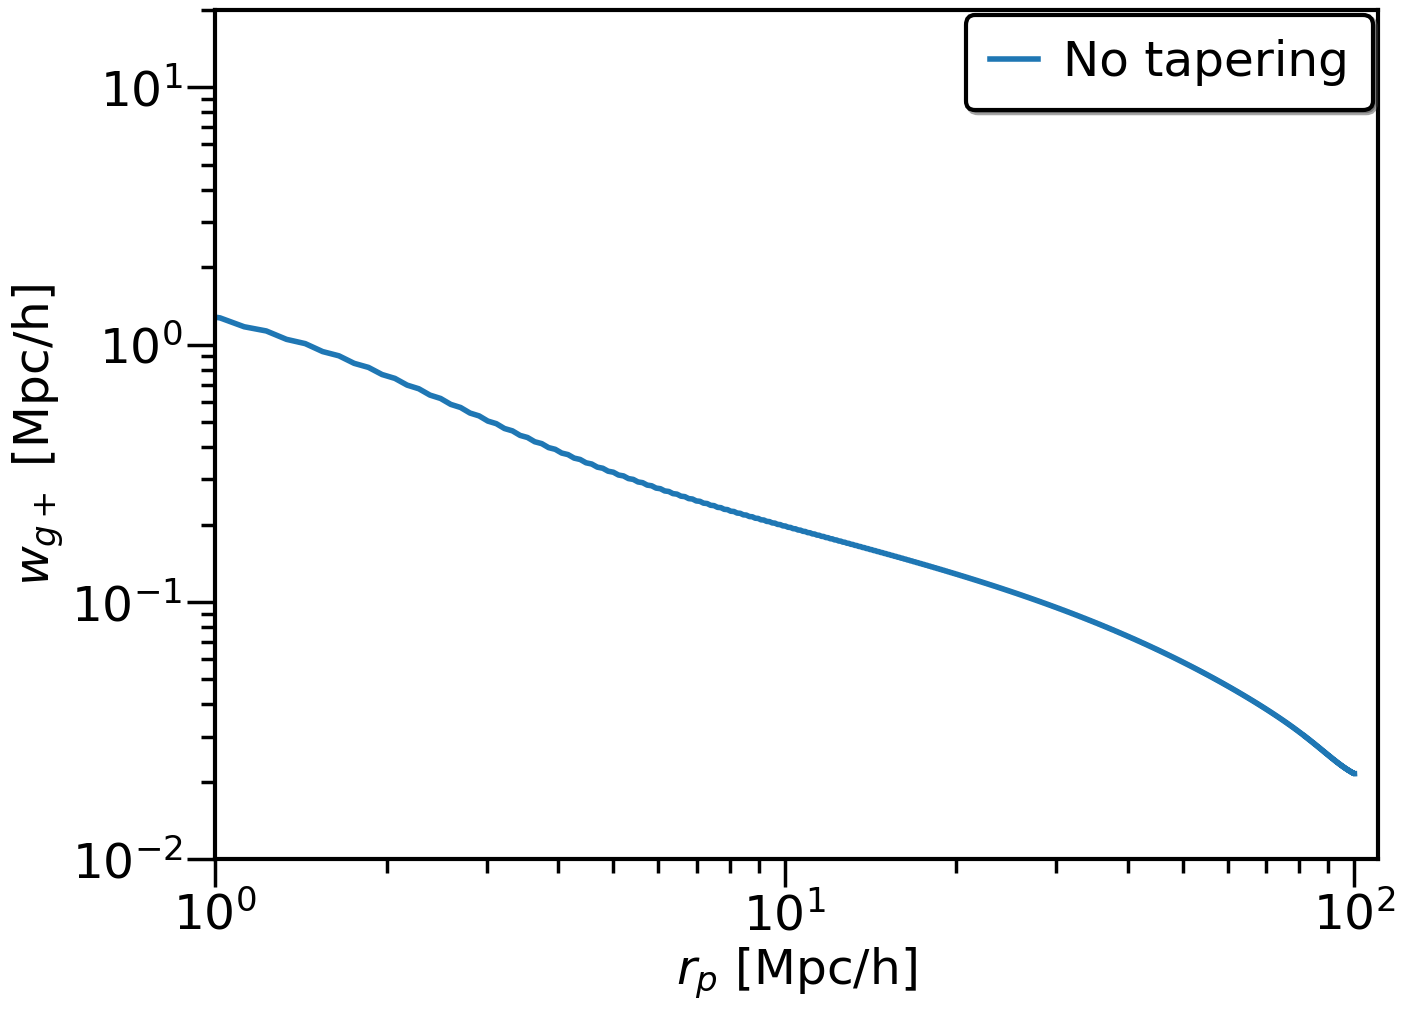

In [20]:
plot(r_gp,wgp,label='No tapering')
xscale('log')
yscale('log')
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{g+}$ [Mpc/h]')
ylim(1.e-2,20)
legend()

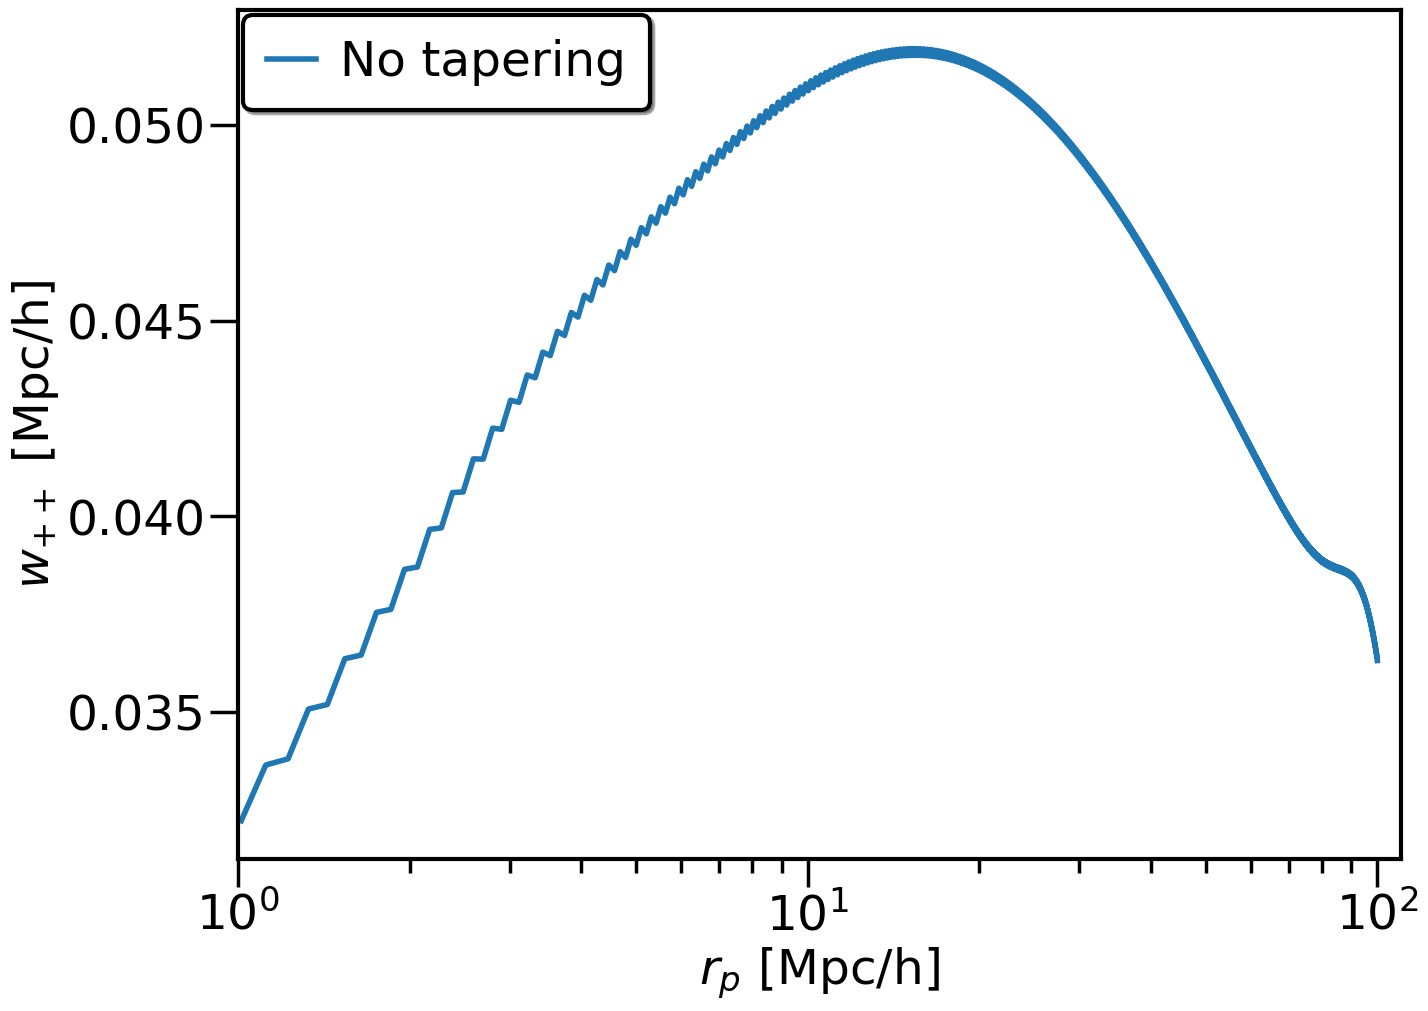

In [21]:
plot(r_pp,r_pp*wpp,label='No tapering')
xscale('log')
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{++}$ [Mpc/h]')
# ylim(0,72)
legend()

Text(0.5, 0, '$r_p$ [Mpc/h]')

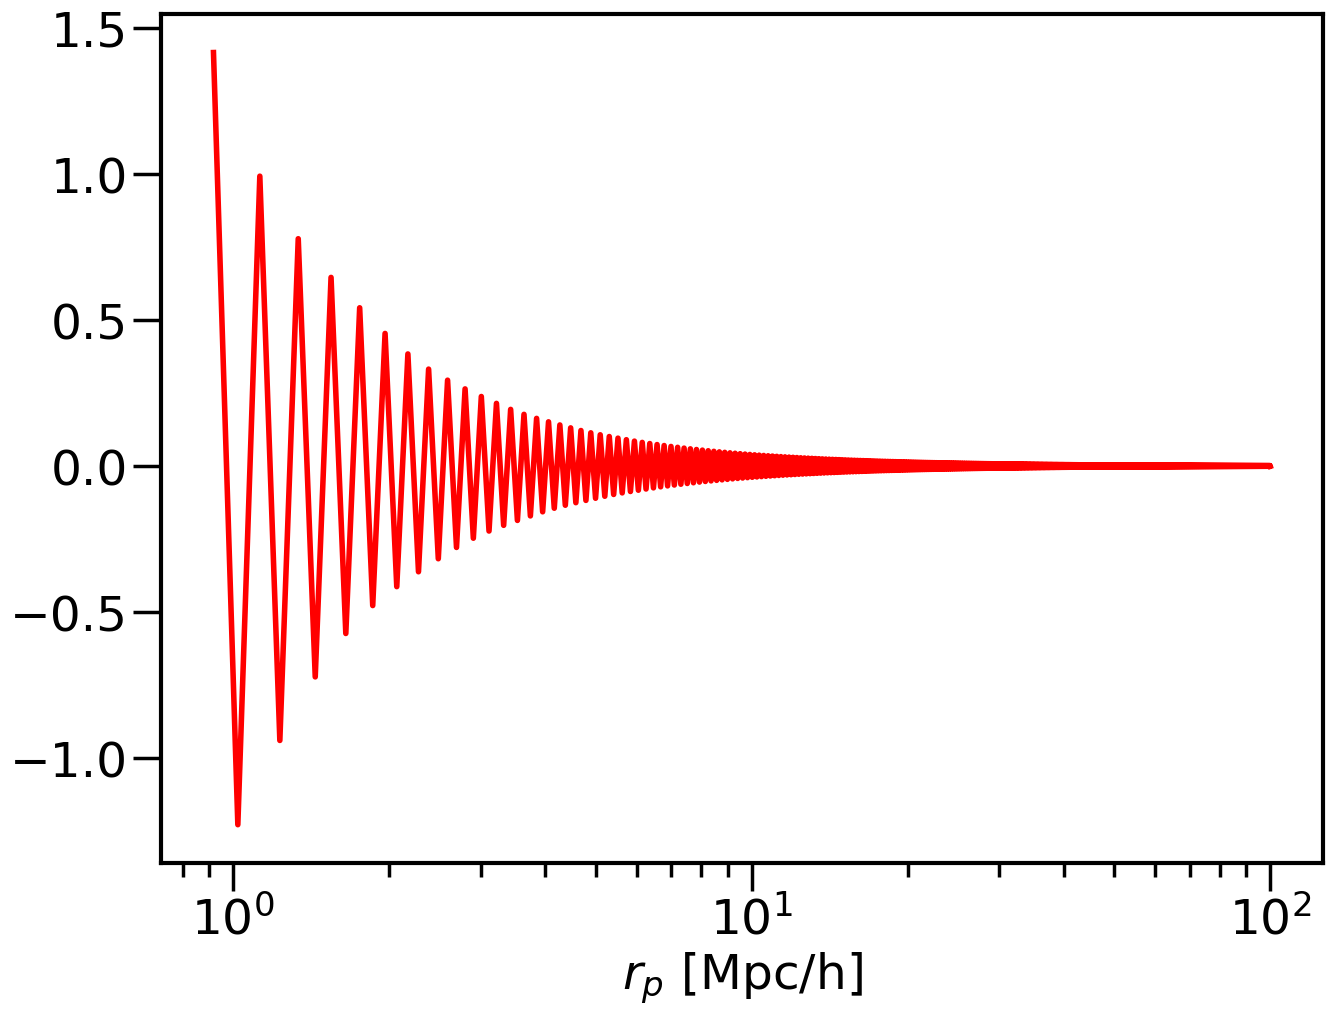

In [22]:
plot(r_gg,wgg-wgg_taper,'r')
xscale('log')
xlabel('$r_p$ [Mpc/h]')

# Covariance

In [23]:
n_g=3.e-4 #number density.. in units of Mpc ^ -3, same as pk
g_shot_noise=1./n_g
b_g=1.8
p_g=pk[0]*wgg_f

In [24]:
sigma_e=.36
sigma_gamma=sigma_e/1.7
n_s=n_g #shape galaxy number density 
shape_noise=sigma_gamma**2/n_s#*cosmo.H_z(z=0.27)/cosmo.c
#shape noise is assumed to be per component
p_gk=pk[0]*wgp_f
p_kk=pk[0]*wpp_f

In [25]:
#lensing contribution. For sims, you can set p_kappa to 0
l=np.unique(np.int32(kh*cosmo.comoving_transverse_distance(z_mean).value))
l,cl=PS.kappa_cl(zs1=[z_mean],zs2=[z_mean],p_zs1=[1],p_zs2=[1],pk_func=PS.camb_pk,zl_max=z_mean,l=l) #set to class_pk if using class
p_kappa=cl*cosmo.comoving_transverse_distance(z_mean)**3 / 2 #this is an approximation
k_kappa=l/cosmo.comoving_transverse_distance(z_mean)
p_kappa_int=interp1d(k_kappa,p_kappa,bounds_error=False, fill_value=0)
p_kappa=p_kappa_int(kh)

Note: redshifts have been re-sorted (earliest first)


/verafs/scratch/phy200040p/sukhdeep/project/code/python_scripts/power_spectra.py:256: RuntimeWarning: divide by zero encountered in true_divide
  pk_int=interp1d(lz,pk[i]/DC_i**2,bounds_error=False,fill_value=0)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/verafs/scratch/phy200040p/sukhdeep/project/code/python_scripts/power_spectra.py:288: RuntimeWarning: divide by zero encountered in true_divide
  f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017


[]

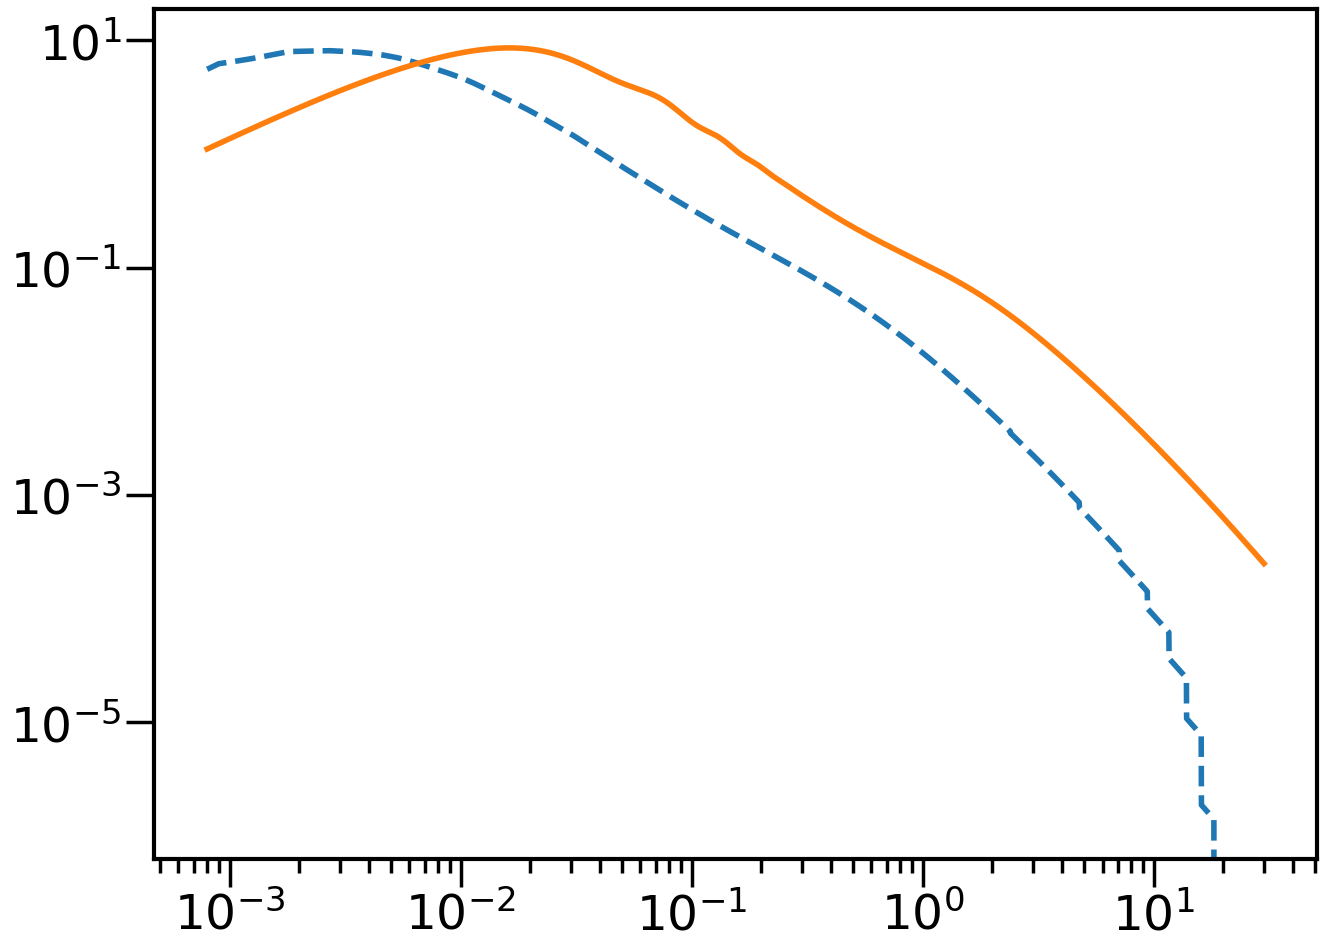

In [26]:
plot(kh,p_kappa,'--')
plot(kh,p_kk)
loglog()

In [27]:
area=8000 #sq. degrees
area_comoving=area*(np.pi/180)**2*cosmo.comoving_distance(z=z_mean)**2
L_W=cosmo.comoving_distance(z=z_max)-cosmo.comoving_distance(z=z_min)
vol=area_comoving*L_W
vol=vol.value
area_comoving=area_comoving.value

#for sims, use the box dimensions to get area and volume.

In [28]:
p_g_cov=p_g+g_shot_noise
p_kk_cov=p_kk+p_kappa+shape_noise
p_gk_cov=p_gk

In [29]:
r,cov_ggkk=HT.projected_covariance(k_pk=kh,pk1=p_g_cov,pk2=p_kk_cov,j_nu=2)
r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/verafs/scratch/phy200040p/sukhdeep/project/code/python_scripts/hankel_transform.py:130: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [30]:
r,cov_gkgk=HT.projected_covariance(k_pk=kh,pk1=p_gk_cov,pk2=p_gk_cov,j_nu=2)
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

In [31]:
cov_final=(cov_ggkk_re+cov_gkgk_re)/area_comoving
corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)

In [32]:
lowz_dat=np.genfromtxt('./test_Dat/lowz_full.dat',names=True)
lowz_cov=np.genfromtxt('./test_Dat//lowz_wgp_cov.dat')
lowz_corr=HT.corr_matrix(cov=lowz_cov)

/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


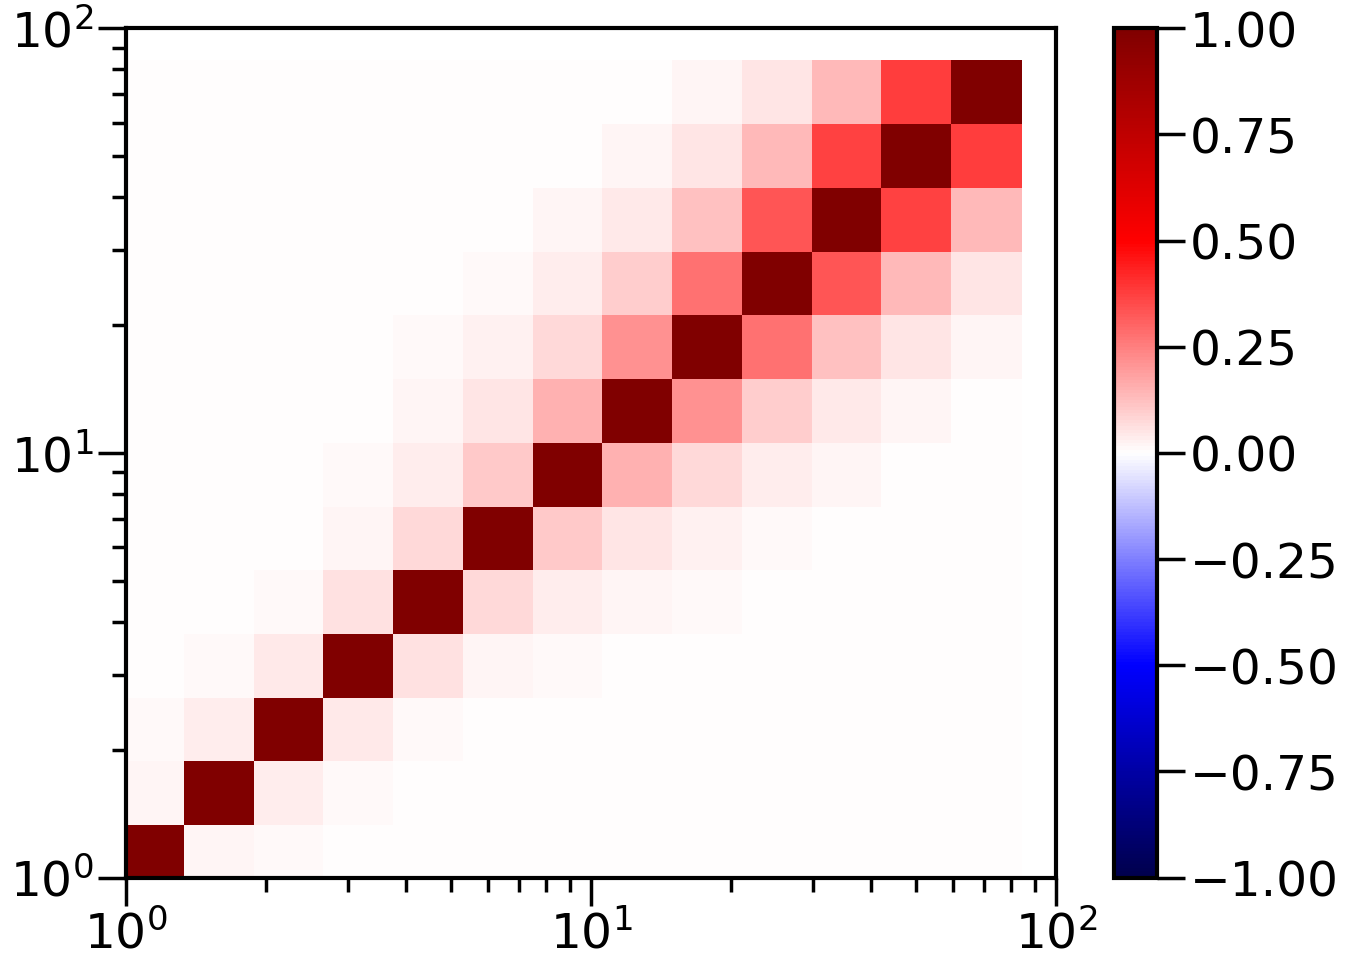

/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


(1, 100)

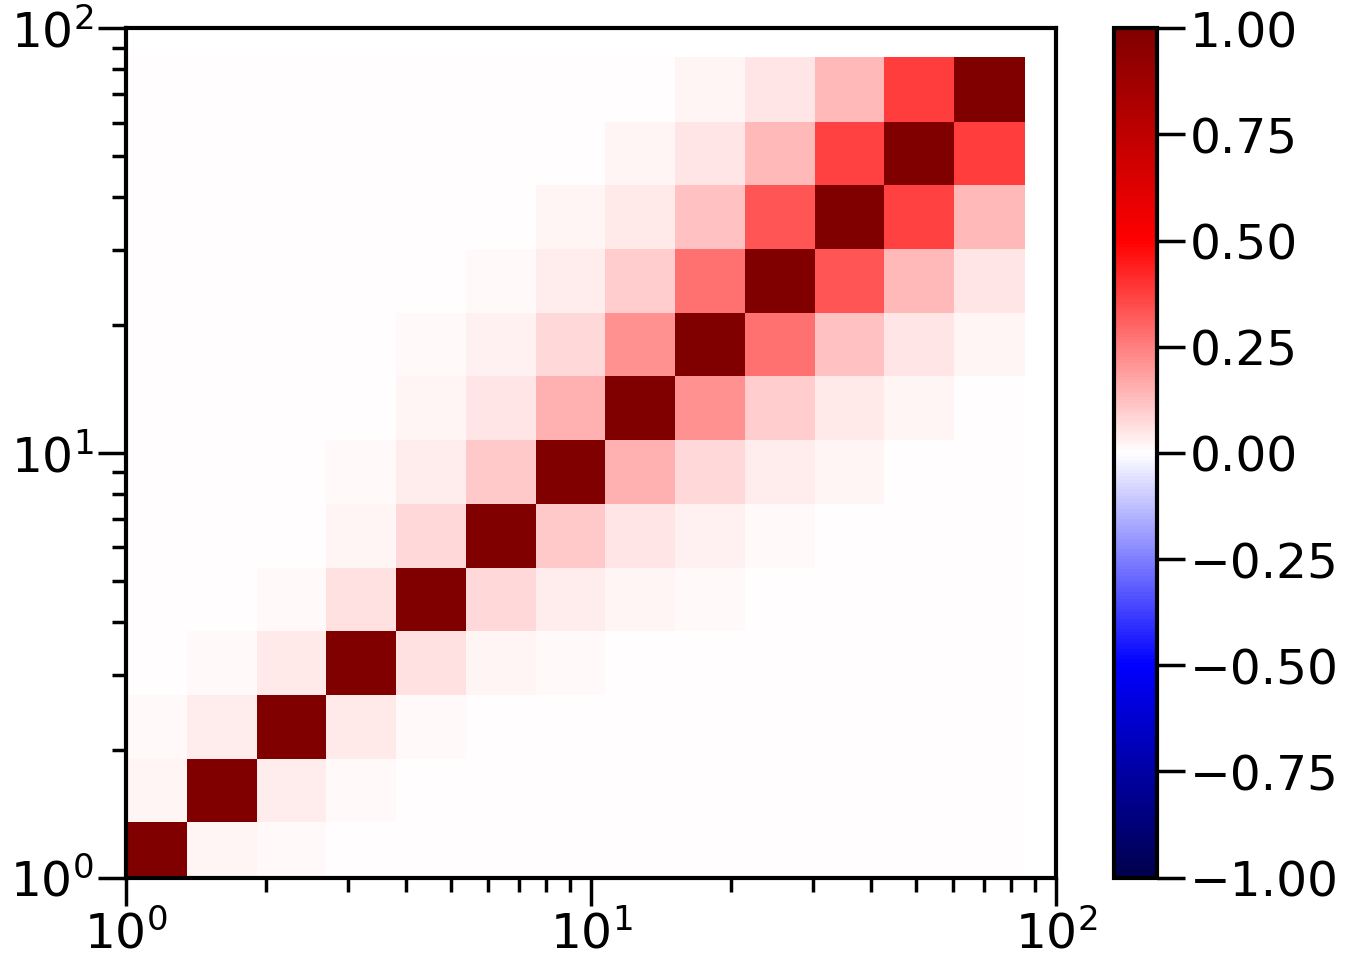

In [33]:
pcolor(r_re,r_re,corr,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(HT.rmin,HT.rmax)
ylim(HT.rmin,HT.rmax)
# colorbar()
show()
pcolor(lowz_dat['rp'],lowz_dat['rp'],corr,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(HT.rmin,HT.rmax)
ylim(HT.rmin,HT.rmax)
# colorbar()

(1, 110)

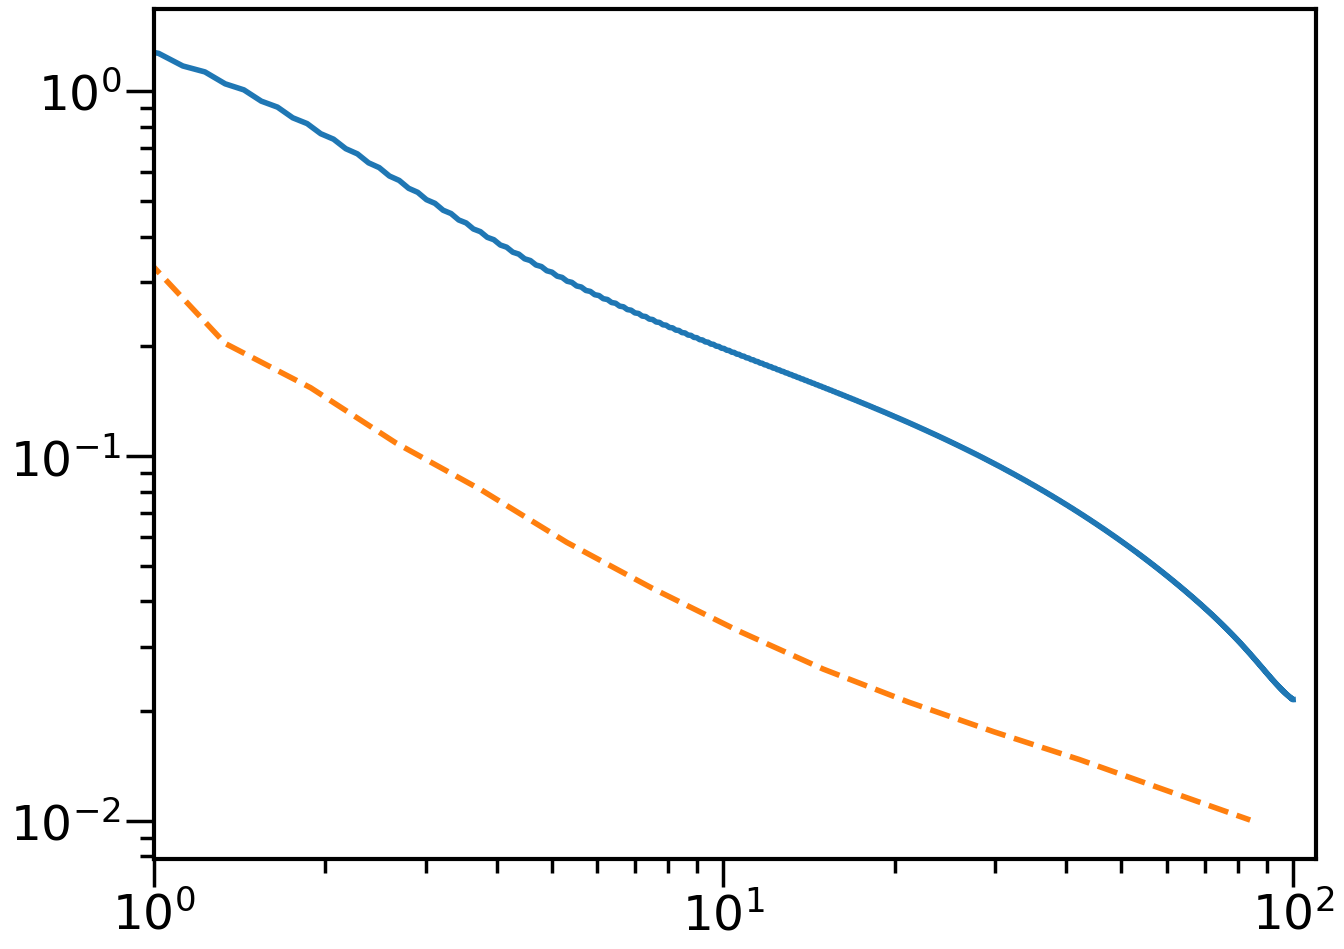

In [34]:
plot(r_gp,wgp)
plot(r_re,errors,'--')
xscale('log')
yscale('log')
xlim(1,110)

(0.009, 2)

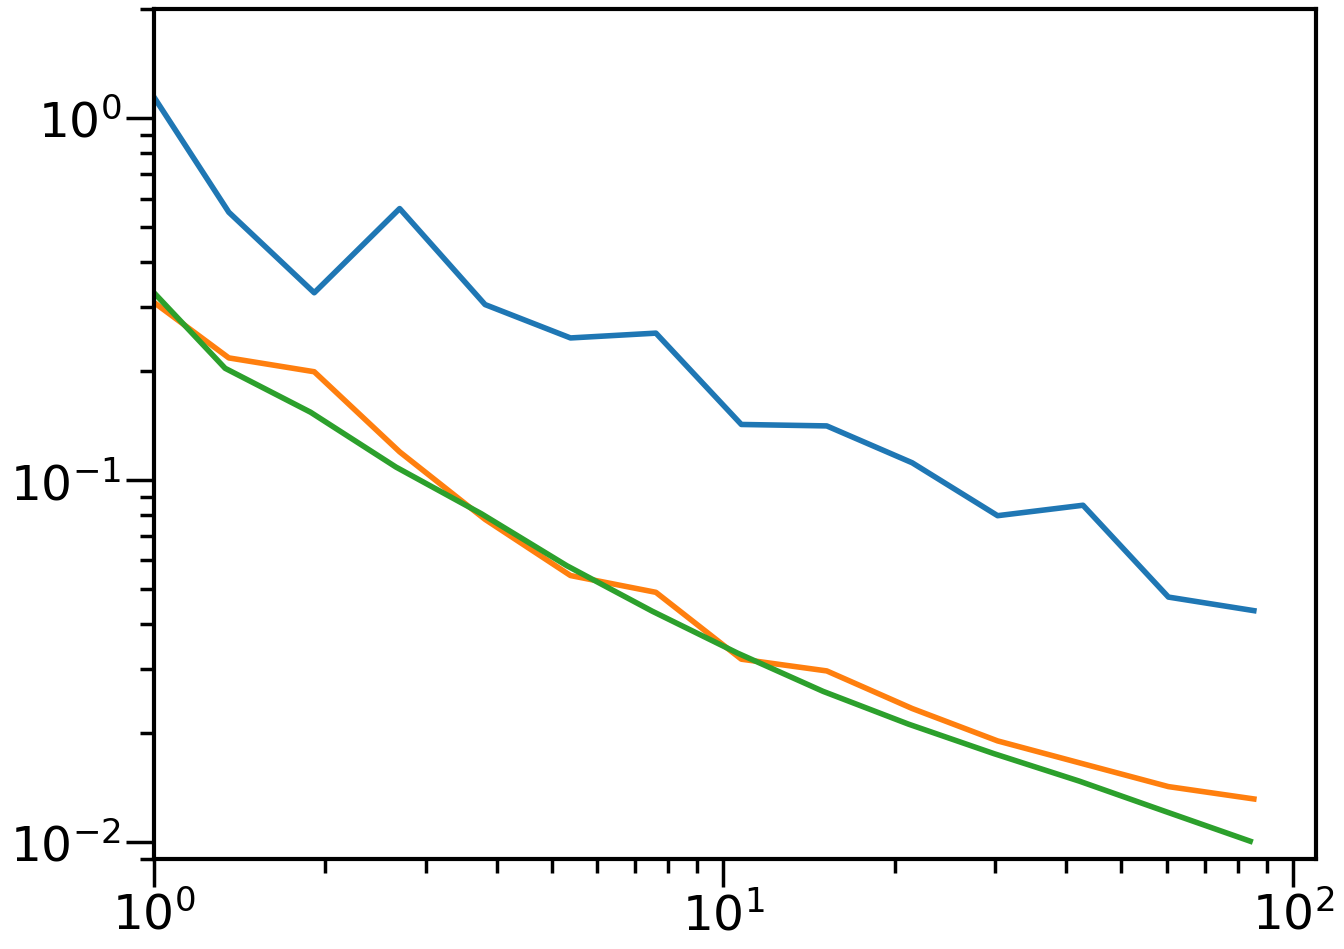

In [35]:
# plot(r_gp,wgp)
plot(lowz_dat['rp'],lowz_dat['wgp'])
plot(lowz_dat['rp'],np.sqrt(np.diag(lowz_cov)))
plot(r_re,errors)
xscale('log')
yscale('log')
xlim(1,110)
ylim(9.e-3,2)

# Wigner Transform

In [36]:
chi=cosmo_h.comoving_transverse_distance(z=z_mean).value
ell=np.unique(np.int32(HT.k[0]*chi))

In [37]:
theta=HT.r[0]/chi

In [38]:
from wigner_transform import *
WT_kwargs={'l': ell,'theta': theta,'s1_s2':[(0,2),(2,0),(0,0),(2,2),(2,-2)]} #(2,2),(2,-2)
%time WT=wigner_transform(**WT_kwargs)

/verafs/scratch/phy200040p/sukhdeep/project/Public-code/Hankel_transform/wigner_functions.py:46: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
/verafs/scratch/phy200040p/sukhdeep/project/Public-code/Hankel_transform/wigner_functions.py:46: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
/verafs/scratch/phy200040p/sukhdeep/project/Public-code/Hankel_transform/wigner_functions.py:46: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 1.76 s, sys: 4.41 s, total: 6.17 s
Wall time: 2min 45s


In [39]:
WT.wig_d.keys()

dict_keys([(0, 2), (2, 0), (0, 0), (2, 2), (2, -2)])

In [40]:
r_ggW,wggW=WT.projected_correlation(l_cl=kh*chi,cl=pk[0]*wgg_f/chi**2,s1_s2=(0,0))

r_gpW,wgpW=WT.projected_correlation(l_cl=kh*chi,cl=pk[0]*wgp_f/chi**2,s1_s2=(0,2))


r_ppW,wppW4=WT.projected_correlation(l_cl=kh*chi,cl=pk[0]*wpp_f/chi**2,s1_s2=(2,-2))
r_pp0W,wppW0=WT.projected_correlation(l_cl=kh*chi,cl=pk[0]*wpp_f/chi**2,s1_s2=(2,2))

wppW=wppW0+wppW4
r_ggW=r_ggW*chi
r_gpW=r_gpW*chi
r_ppW=r_ppW*chi

[]

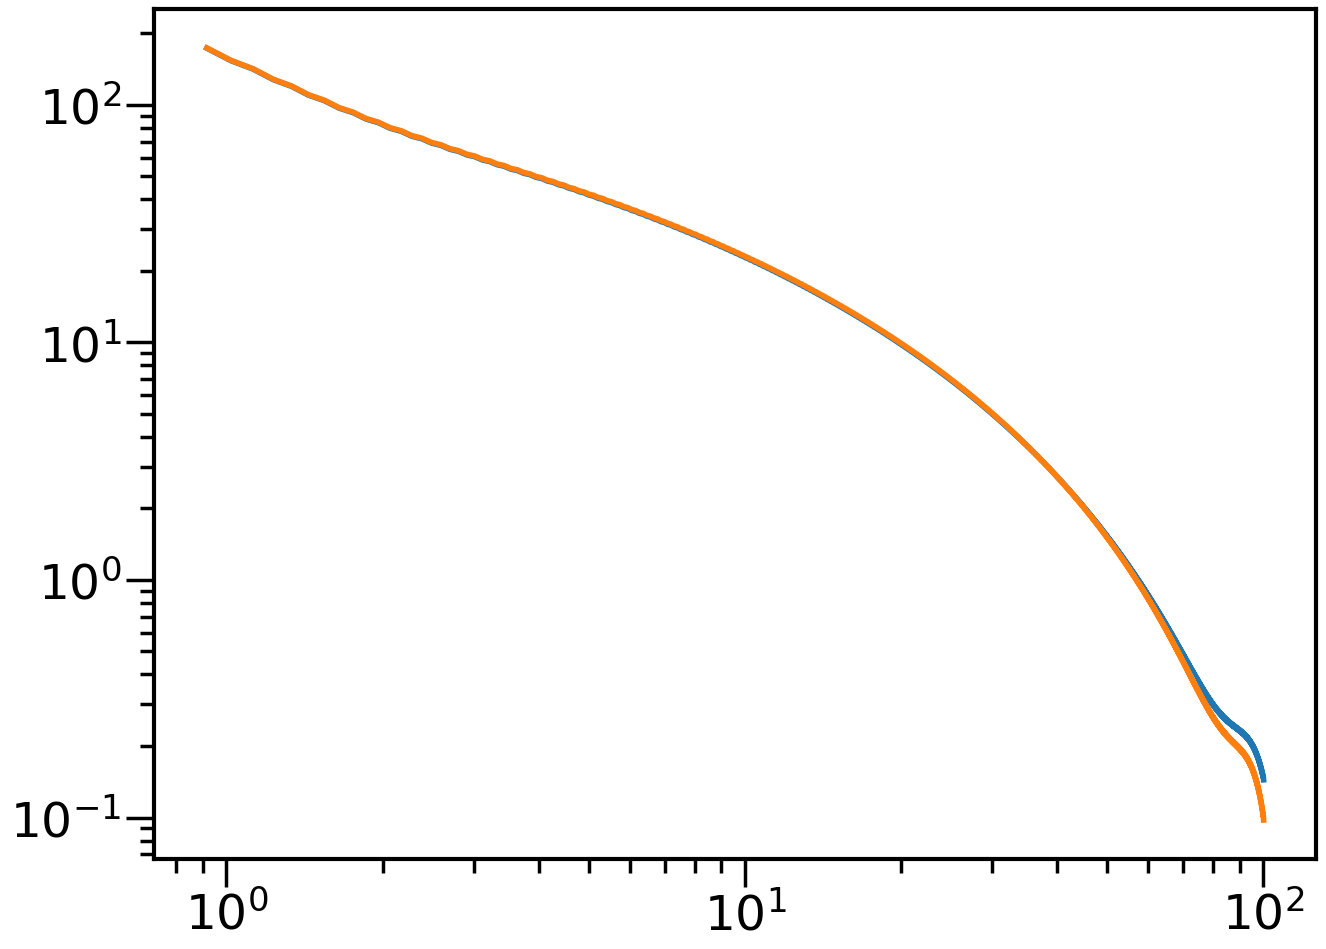

In [41]:
plot(r_gg,wgg)
plot(r_ggW,wggW)
loglog()

[]

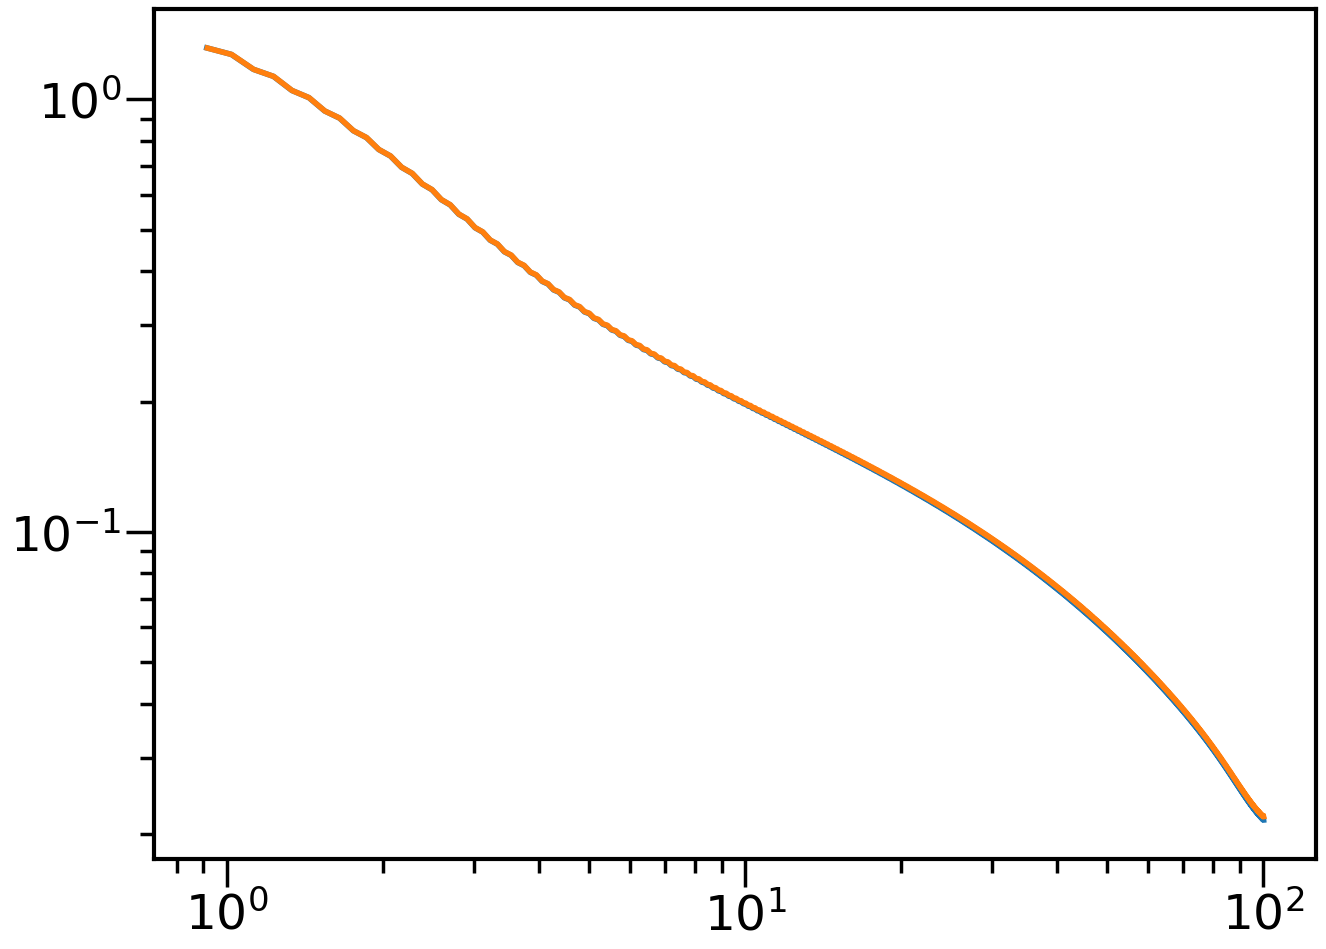

In [42]:
plot(r_gp,wgp)
plot(r_gpW,wgpW)
loglog()

[]

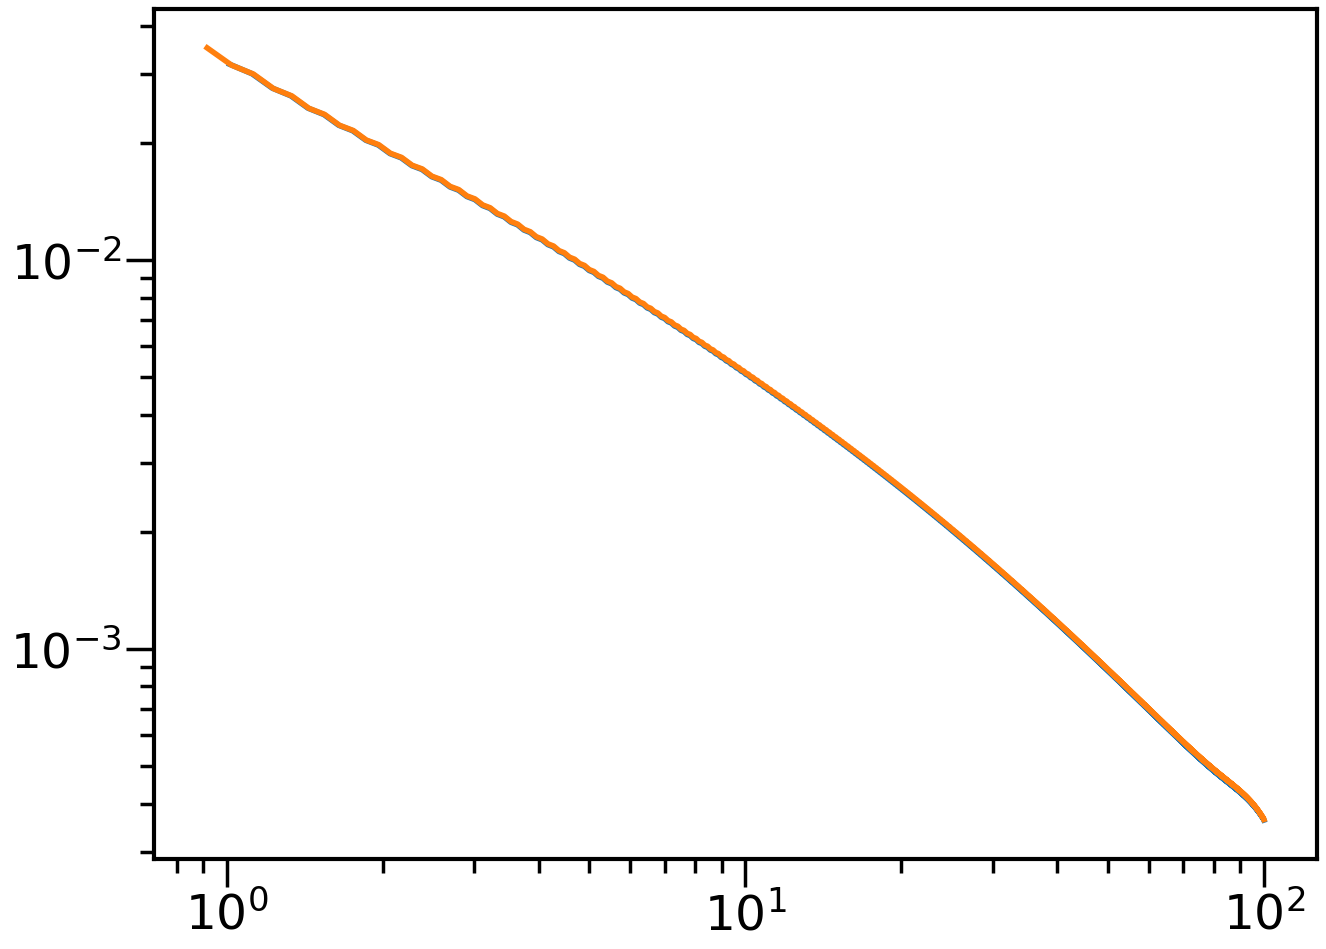

In [43]:
plot(r_pp,wpp)
plot(r_ppW,wppW)
loglog()

In [44]:
#wgp auto-covariance
rW,cov_ggkkW=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_g_cov*p_kk_cov/chi**2,s1_s2=(0,2))
rW=rW*chi
r_reW,cov_ggkk_reW=HT.bin_cov(r=rW,cov=cov_ggkkW,r_bins=r_bins)
# corr=HT.corr_matrix(cov=cov_ggkk_reW)


rW,cov_gkgkW=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_gk_cov*p_gk_cov/chi**2,s1_s2=(0,2))
rW=rW*chi
r_reW,cov_gkgk_reW=HT.bin_cov(r=rW,cov=cov_gkgkW,r_bins=r_bins)
# corr=HT.corr_matrix(cov=cov_gkgk_reW)


cov_finalW=(cov_ggkk_reW+cov_gkgk_reW)/area_comoving
corrW=HT.corr_matrix(cov=cov_finalW)
errorsW=HT.diagonal_err(cov=cov_finalW)

/verafs/scratch/phy200040p/sukhdeep/project/code/python_scripts/hankel_transform.py:130: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


(1, 100)

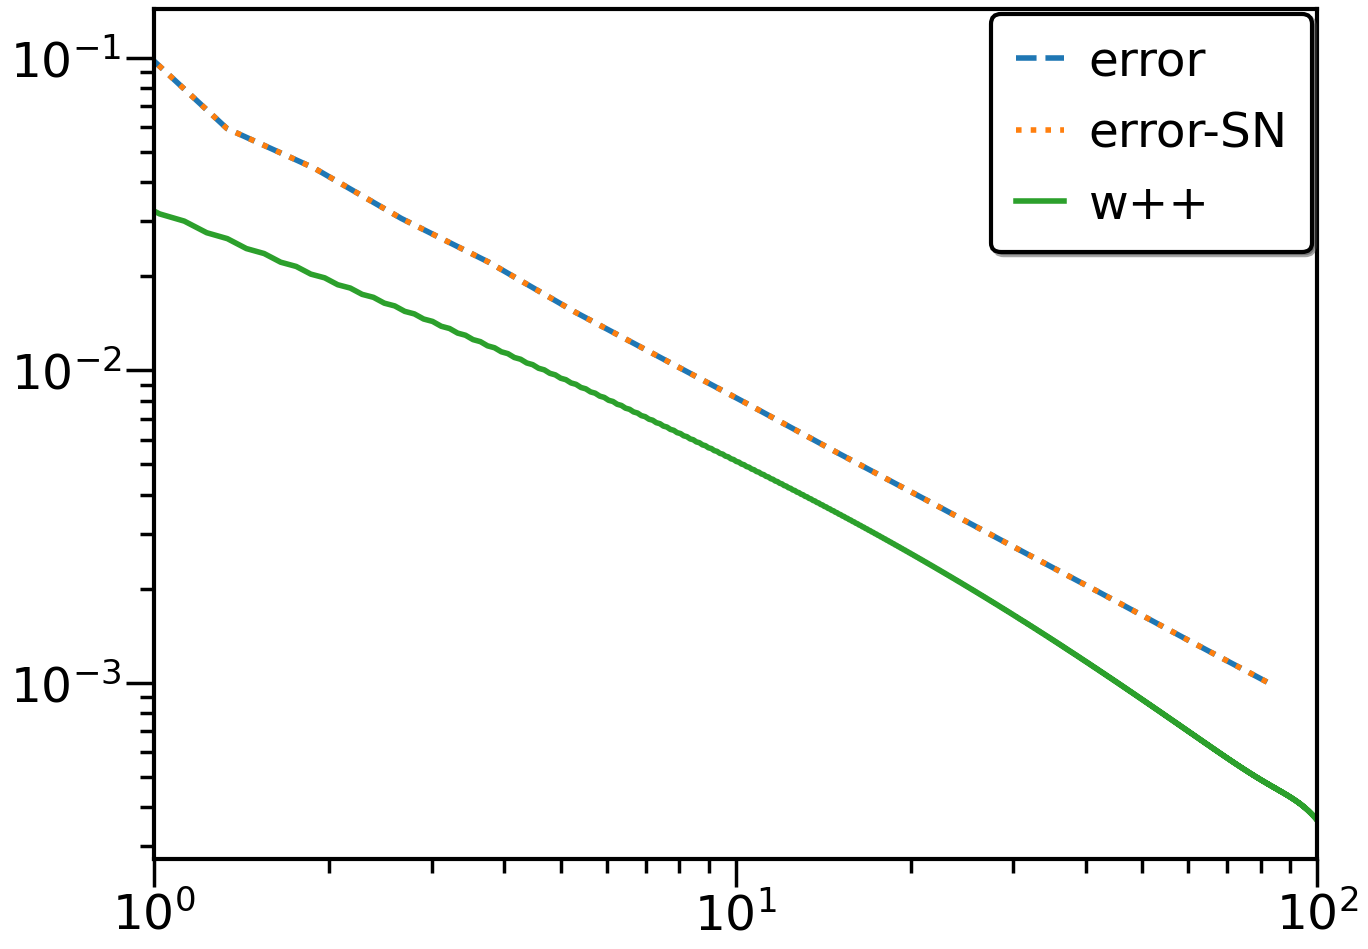

In [45]:
#wpp auto-covariance
#wpp = 0.5*(xi_+ + xi_-)
#For the form of equation we use, see https://arxiv.org/pdf/0708.0387.pdf, eq. 29-31, we assume P_B=0.
# here, 0=> xi_+ and 4=>xi_-
rW,cov_kkkkW0=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_kk_cov*p_kk_cov/chi**2,s1_s2=(2,2))
rW,cov_kkkkW4=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_kk_cov*p_kk_cov/chi**2,s1_s2=(2,-2))
rW,cov_kkkkW04=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_kk_cov*p_kk_cov/chi**2,s1_s2=(2,-2),s1_s2_cross=(2,2))

#shape noise is assumed to be per component. We need to add B-mode contribution from shape noise.
P_SN=np.ones_like(kh)*shape_noise
rW,cov_kkkkW0_SN=WT.projected_covariance(l_cl=kh*chi,cl_cov=P_SN*P_SN/chi**2,s1_s2=(2,2))
cov_kkkkW0+= cov_kkkkW0_SN
rW,cov_kkkkW4_SN=WT.projected_covariance(l_cl=kh*chi,cl_cov=P_SN*P_SN/chi**2,s1_s2=(2,-2))
cov_kkkkW4+= cov_kkkkW4_SN

#cross covariance has shape noise term with negative sign
rW,cov_kkkkW04_SN=WT.projected_covariance(l_cl=kh*chi,cl_cov=P_SN*P_SN/chi**2,s1_s2=(2,-2),s1_s2_cross=(2,2))
cov_kkkkW04-= cov_kkkkW04_SN

# Note covariance has two components, which are same for auto correlation. 
# Hence we multiply with 2. This factor is implicitly taken care of in Joachimi+
# Since the wpp is sum of two terms, we add their covariance in quadrature.
cov_kkkkW=2*cov_kkkkW0+2*cov_kkkkW4+2*2*(cov_kkkkW04)
cov_kkkkW/=4
rW=rW*chi
r_reW,cov_kkkk_reW=HT.bin_cov(r=rW,cov=cov_kkkkW,r_bins=r_bins)
r_reW,cov_kkkk0_SN_reW=HT.bin_cov(r=rW,cov=cov_kkkkW0_SN,r_bins=r_bins)

cov_finalW=(cov_kkkk_reW)/area_comoving
corrW=HT.corr_matrix(cov=cov_finalW)
errorsW=HT.diagonal_err(cov=cov_finalW)
errorsW_SN=HT.diagonal_err(cov=cov_kkkk0_SN_reW/area_comoving)

plot(r_reW,errorsW,'--',label='error')
plot(r_reW,errorsW,':',label='error-SN')#shape noise is the dominant contribution.
plot(r_ppW,wppW,label='w++')
loglog()
legend()
xlim(1,100)

In [46]:
#wgg auto-covariance
rW,cov_ggggW=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_g_cov*p_g_cov/chi**2,s1_s2=(0,0))
rW=rW*chi
r_reW,cov_gggg_reW=HT.bin_cov(r=rW,cov=cov_ggggW,r_bins=r_bins)

cov_gg_finalW=(cov_gggg_reW*2)/area_comoving
corr_ggW=HT.corr_matrix(cov=cov_gg_finalW)
errors_ggW=HT.diagonal_err(cov=cov_gg_finalW)

/verafs/scratch/phy200040p/sukhdeep/project/code/python_scripts/hankel_transform.py:130: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [47]:
#wgp-wgg cross-covariance

rW,cov_gggkW=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_g_cov*p_gk_cov/chi**2,s1_s2=(0,2),s1_s2_cross=(0,0))
rW=rW*chi
r_reW,cov_gggk_reW=HT.bin_cov(r=rW,cov=cov_gggkW,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_ggkk_reW)


cov_cross_finalW=(cov_gggk_reW*2)/area_comoving  #we are assuming same z-bins for wgg and IA measurements
corr_crossW=cov_cross_finalW/(np.outer(errorsW,errors_ggW))

/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


(1, 110)

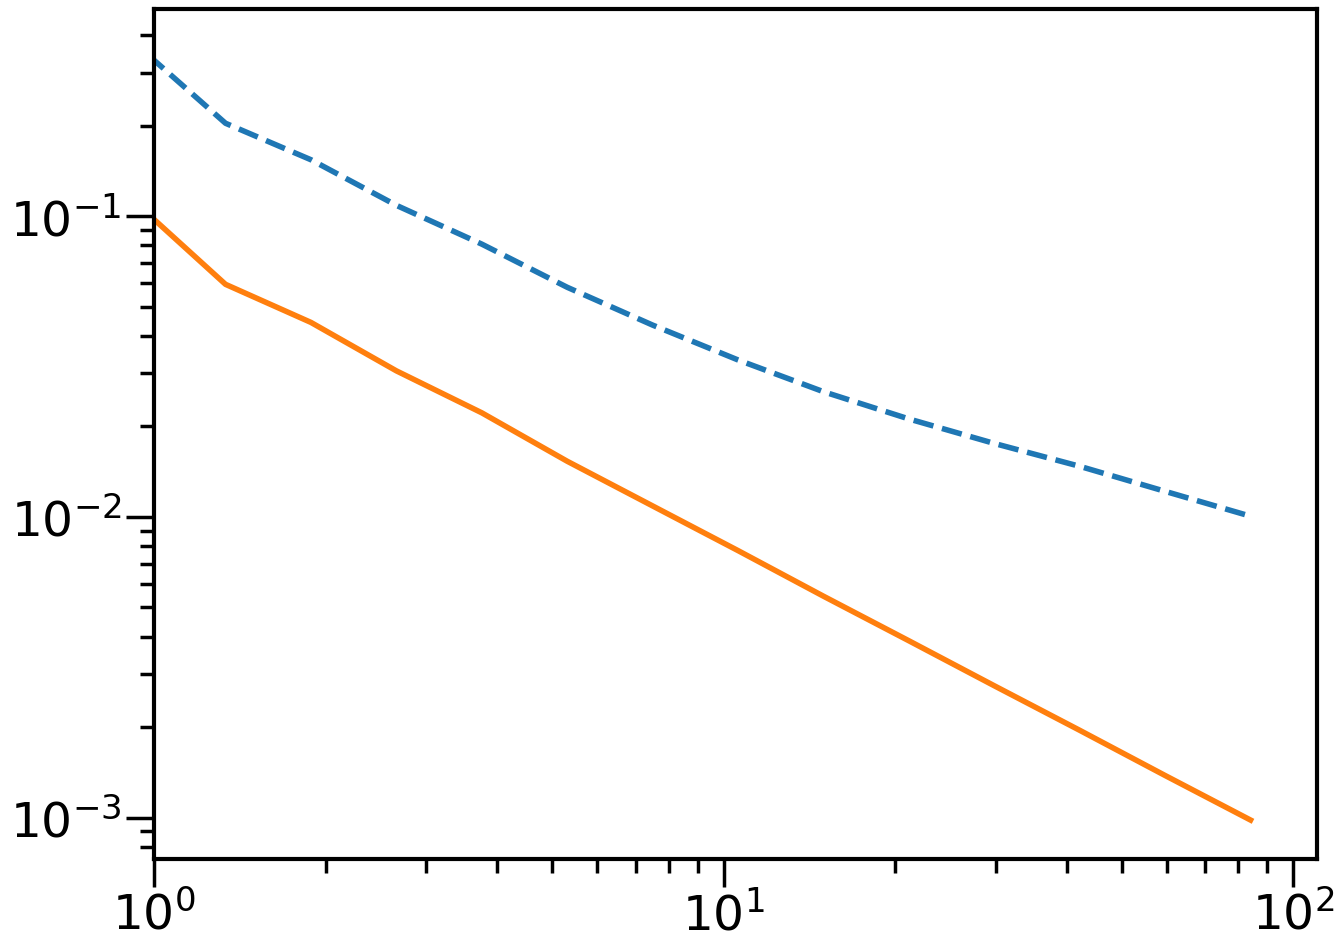

In [48]:
# plot(r_gp,wgp)
plot(r_re,errors,'--')
plot(r_reW,errorsW,'-')
xscale('log')
yscale('log')
xlim(1,110)

/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


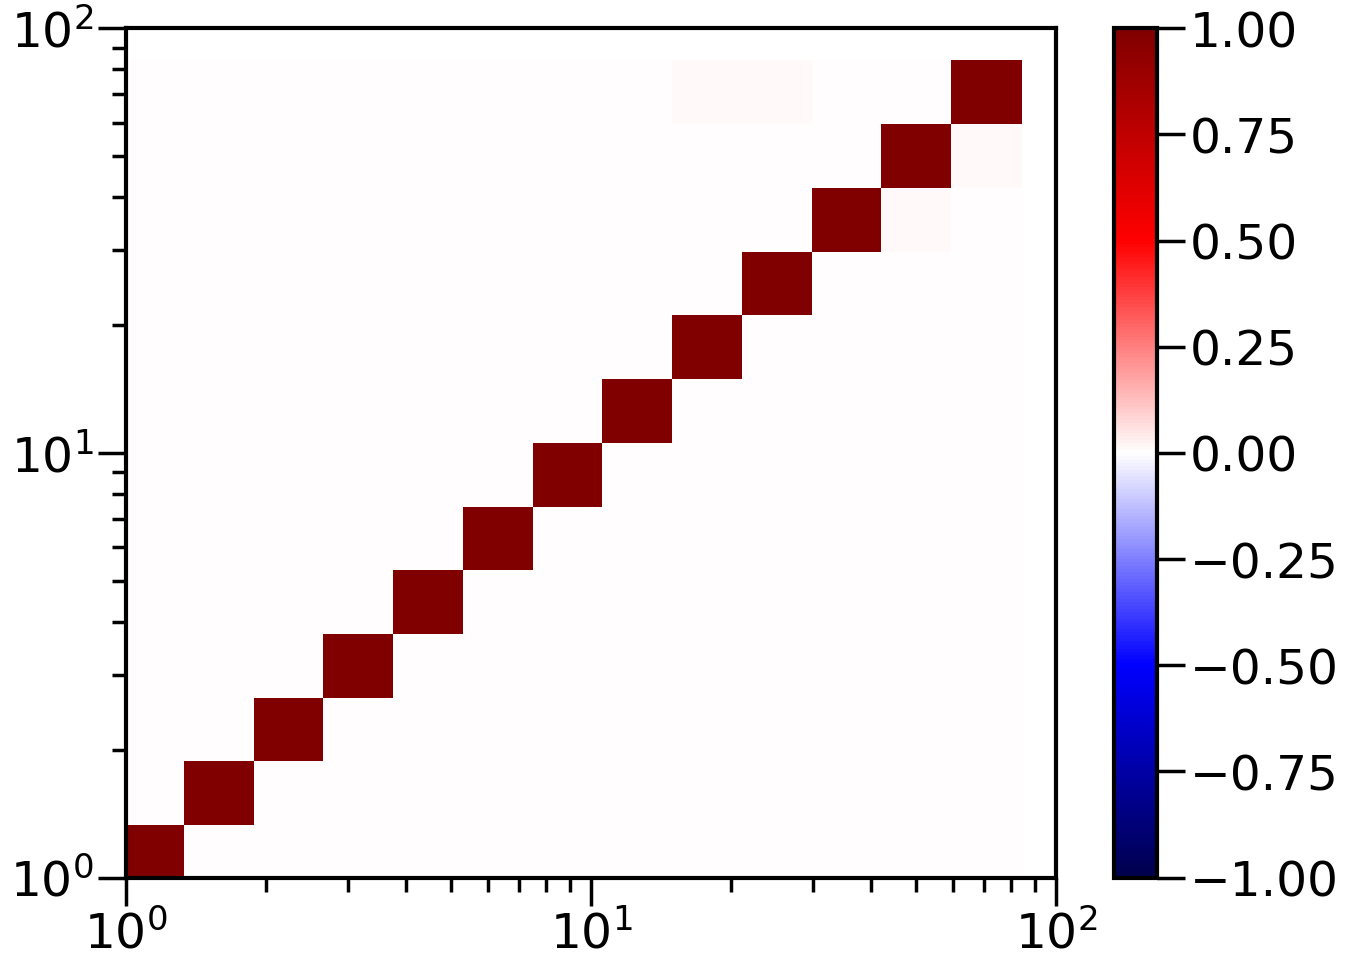

/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


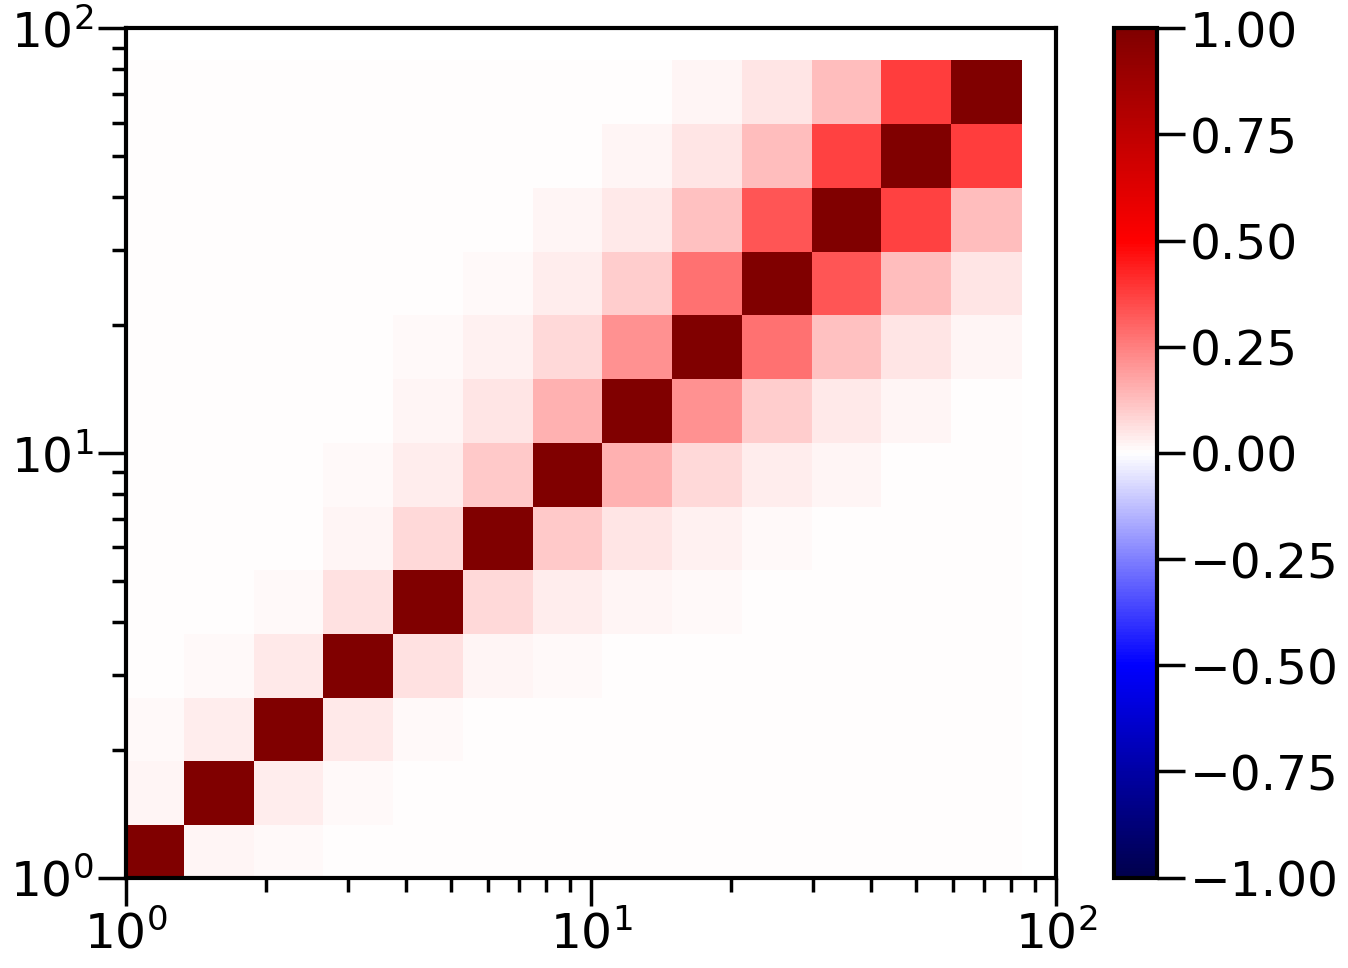

In [49]:
pcolor(r_reW,r_reW,corrW,vmin=-1,vmax=1,cmap='seismic')
xlim(1,100)
ylim(1,100)
loglog()
colorbar()
show()
pcolor(r_reW,r_reW,corr,vmin=-1,vmax=1,cmap='seismic')
loglog()
colorbar()
xlim(1,100)
ylim(1,100)
show()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


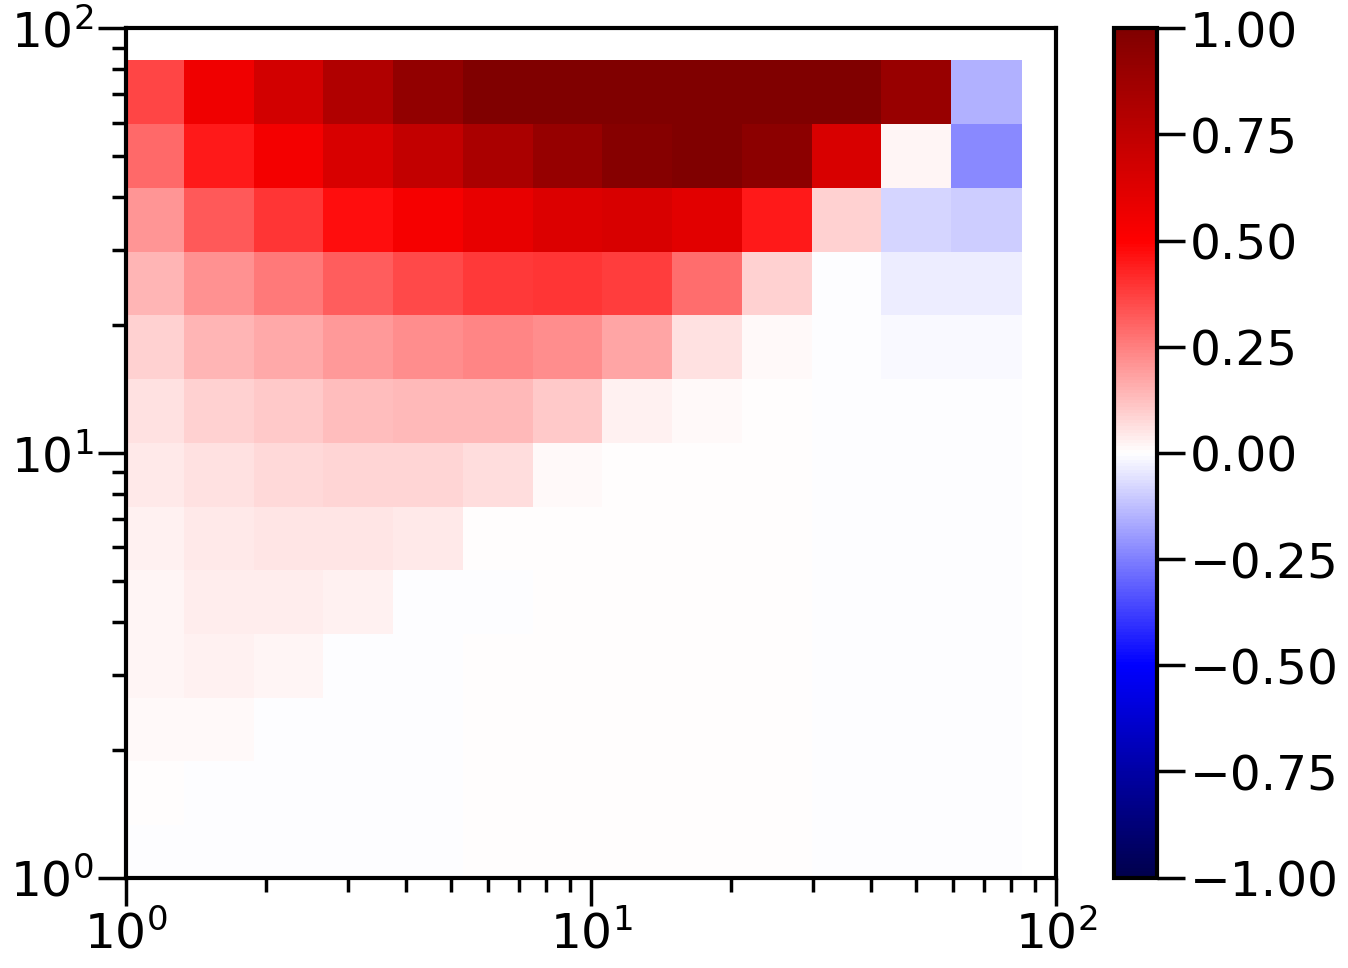

In [50]:
pcolor(r_reW,r_reW,corr_crossW,vmin=-1,vmax=1,cmap='seismic')
xlim(1,100)
ylim(1,100)
loglog()
colorbar()
show()

# $\Pi_{max}$ limits

In [57]:
from projected_corr_rsd import *
#need mcfit... pip install mcfit

In [117]:
rp=np.logspace(-2,2,1000) #need rp_low to be small when computing delta sigma or wg+. 
pi_max=100
pi=np.linspace(0,pi_max,1000) #dpi should be small for integrals to converge. negative pi values are included by multiplying with factor of 2 inside the code.
k=kh

In [118]:
w_class=Projected_Corr_RSD(rp=rp,pi=pi,pi_max=pi_max,l=[0,2,4],k=kh)

/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


In [119]:
f_gg=0 #this should be zero unless working in redshift space
wgg_rsd=w_class.wgg_calc(f=f_gg,bg=1,bg2=None,pk=pk[0]*wgg_f,xi=None,l=[0,2,4])

/verafs/scratch/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.7/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [120]:
beta_gp=-1 #
wgp_rsd=w_class.wgm_calc(f=0,bg=1,beta2=beta_gp,pk=pk[0]*wgp_f,xi=None,l=[0,2,4],do_DS=True)

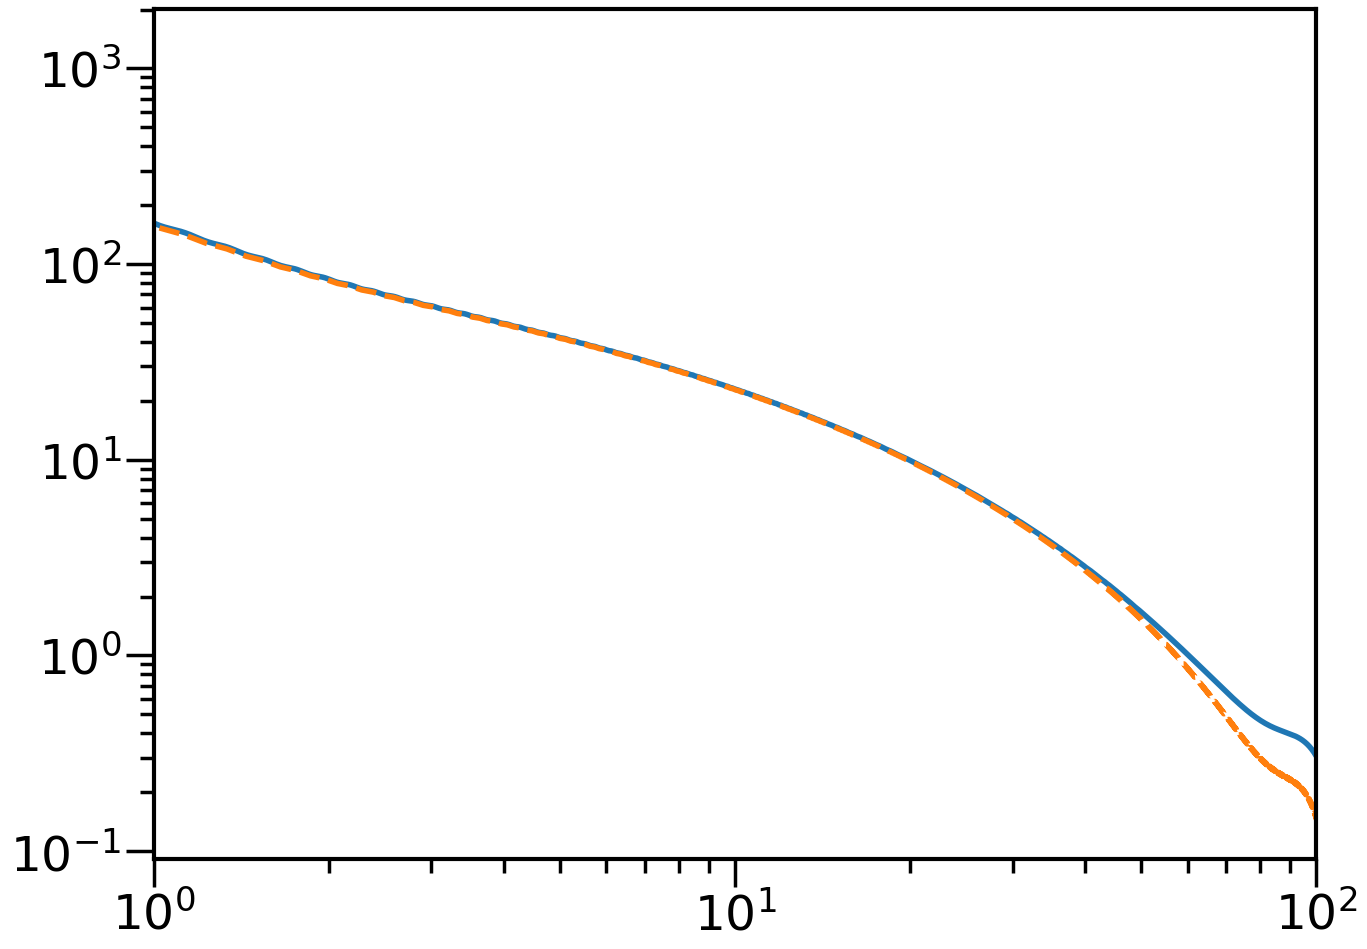

In [122]:
plot(rp,wgg_rsd)
plot(r_gg,wgg*1,'--')
xlim(1,100)
loglog()
show()


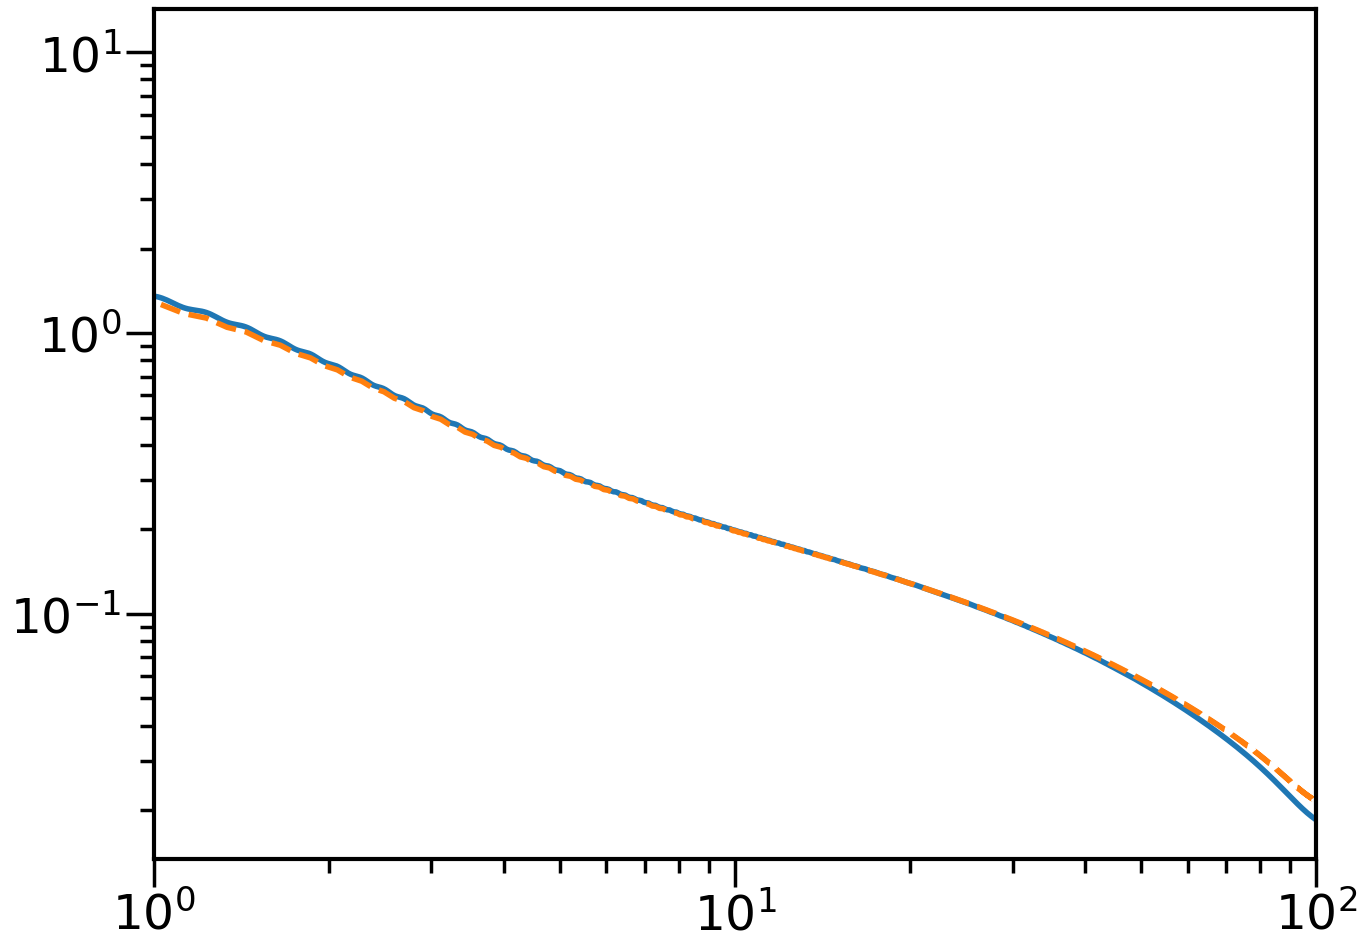

In [123]:
plot(rp,wgp_rsd)
plot(r_gg,wgp,'--')
loglog()
xlim(1,100)
show()